In [1]:
import numpy as np
import scipy
from scipy.sparse import csr_matrix, lil_matrix
from scipy.special import gamma
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from findiff import FinDiff, Identity, PDE, BoundaryConditions
import torch
from torch.utils.data import DataLoader, TensorDataset
import os
os.chdir("/home/so/Documents/Projects/NeuralInterpolation")
from models.siren import Siren

Generate a synthetic Gaussian random field by solving the SPDE
\begin{align}
(\kappa^2 - \Delta) f = \mathcal{W}.
\end{align}

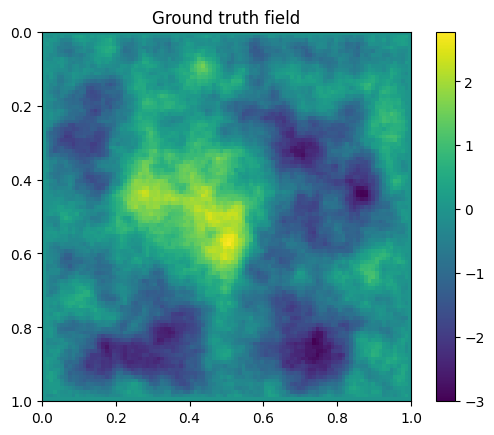

In [2]:
d = 2
ls = 0.15
nu = 1
amp = 1.1
kappa = np.sqrt(2*nu) / ls
q = ((4*np.pi)**(d/2)*kappa**(2*nu)*gamma(nu+d/2))/gamma(nu)
grid_size = 100

x = y = np.linspace(0, 1, grid_size)
X, Y = np.meshgrid(x, y, indexing='ij')
X_test = np.stack([X.flatten(), Y.flatten()], axis=1)

shape = (grid_size, grid_size)
dx = x[1]-x[0]
dy = y[1]-y[0]

# Set LHS
diff_op = kappa**2 * Identity() - FinDiff(0, dx, 2) - FinDiff(1, dy, 2)

# Set RHS
np.random.seed(0)
W = (1/np.sqrt(dx*dy)) * np.sqrt(q) * amp * np.random.randn(*shape)

# Set boundary conditions (zero-Dirichlet)
bc = BoundaryConditions(shape)
bc[0, :] = 0
bc[-1,:] = 0
bc[:, 0] = 0
bc[:, -1] = 0

# Solve PDE
pde = PDE(diff_op, W, bc)
u = pde.solve()

# Plot solution
plt.imshow(u, extent=[0,1,1,0])
plt.colorbar()
plt.title('Ground truth field')
plt.show()

Sample random points for observation

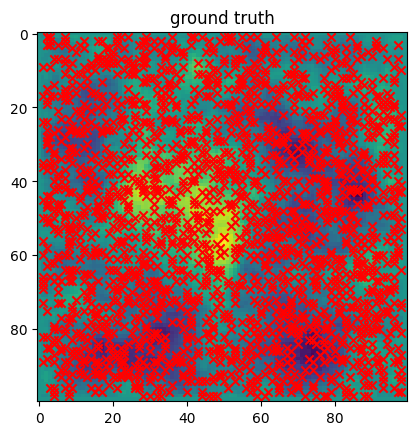

In [3]:
num_obs = 2000
obs_noise = 0

# Get observations at random locations
rng = np.random.default_rng(0)
x_idxs = y_idxs = np.arange(grid_size)
X_idxs, Y_idxs = np.meshgrid(x_idxs[1:-1], y_idxs[1:-1], indexing='ij')
all_idxs = np.stack([X_idxs.flatten(), Y_idxs.flatten()], axis=1)
idxs = rng.choice(all_idxs, num_obs, replace=False)
obs_dict = {tuple(idx): u[tuple(idx)]+obs_noise*np.random.randn() for idx in idxs}

# Plot results
plt.imshow(u)
plt.title('ground truth')
plt.scatter(idxs[:,1], idxs[:,0], c='r', marker='x')

In [4]:
# Create pytorch dataloader
X = list(obs_dict.keys())
Y = list(obs_dict.values())
X = np.array(X)
Y = np.array(Y)
tensor_x = torch.Tensor(X)
tensor_y = torch.Tensor(Y)

my_dataset = TensorDataset(tensor_x/100, tensor_y[:,None]) # create your datset
my_dataloader = DataLoader(my_dataset, batch_size=256, shuffle=True) # create your dataloader

In [5]:
def train_model(model, dataloader, optim, num_epochs=200):
    for epoch in range(num_epochs):
        epoch_loss = 0
        N = 0
        for i, data in enumerate(dataloader):
            model_input, ground_truth = data
            model_input, ground_truth = model_input.cuda(), ground_truth.cuda()
            model_output = model(model_input)    
            loss = ((model_output - ground_truth)**2).mean()
            bs = model_input.shape[0]
            N += bs
            epoch_loss += loss * bs
            optim.zero_grad()
            loss.backward()
            optim.step()
            epoch_loss /= N
        print(f"Epoch {epoch}: loss {epoch_loss}")


def plot_predictions(model, model_name: str, vmin=-3, vmax=3):
    X_test = torch.Tensor(all_idxs).cuda()
    model_output = model(X_test/100)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

    divider1 = make_axes_locatable(ax1)
    im1 = ax1.imshow(u, extent=[0,1,1,0], vmin=vmin, vmax=vmax)
    ax1.set_title('Ground truth')
    cax1 = divider1.append_axes('right', size='5%', pad=0.1)
    fig.colorbar(im1, cax=cax1, orientation='vertical')

    divider2 = make_axes_locatable(ax2)
    im2 = ax2.imshow(model_output.reshape(98,98).cpu().detach().numpy(), extent=[0,1,1,0], vmin=vmin, vmax=vmax)
    ax2.set_title(model_name + ' output')
    cax2 = divider2.append_axes('right', size='5%', pad=0.1)
    fig.colorbar(im2, cax=cax2, orientation='vertical')


# SIREN experiment

In [6]:
img_siren = Siren(in_features=2, out_features=1, hidden_features=256, 
                  hidden_layers=3, outermost_linear=True)

img_siren.cuda()

Siren(
  (net): Sequential(
    (0): SineLayer(
      (linear): Linear(in_features=2, out_features=256, bias=True)
    )
    (1): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (2): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (3): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (4): Linear(in_features=256, out_features=1, bias=True)
  )
)

In [7]:
num_epochs = 200
optim = torch.optim.Adam(lr=1e-4, params=img_siren.parameters())

train_model(img_siren, my_dataloader, optim, num_epochs)

Epoch 0: loss 0.0653611496090889
Epoch 1: loss 0.04373886063694954
Epoch 2: loss 0.028640257194638252
Epoch 3: loss 0.016281694173812866
Epoch 4: loss 0.010988875292241573
Epoch 5: loss 0.01019288320094347
Epoch 6: loss 0.005189506337046623
Epoch 7: loss 0.005946940742433071
Epoch 8: loss 0.006057036109268665
Epoch 9: loss 0.004805536940693855
Epoch 10: loss 0.004909577779471874
Epoch 11: loss 0.00423388322815299
Epoch 12: loss 0.002929861191660166
Epoch 13: loss 0.0025006895884871483
Epoch 14: loss 0.002421836368739605
Epoch 15: loss 0.0029542064294219017
Epoch 16: loss 0.002360040321946144
Epoch 17: loss 0.0019813133403658867
Epoch 18: loss 0.00270311301574111
Epoch 19: loss 0.0024854836519807577
Epoch 20: loss 0.002498943591490388
Epoch 21: loss 0.0025647582951933146
Epoch 22: loss 0.001900074421428144
Epoch 23: loss 0.0019940014462918043
Epoch 24: loss 0.0018039882415905595
Epoch 25: loss 0.0017163327429443598
Epoch 26: loss 0.0014118473045527935
Epoch 27: loss 0.001218096120283007

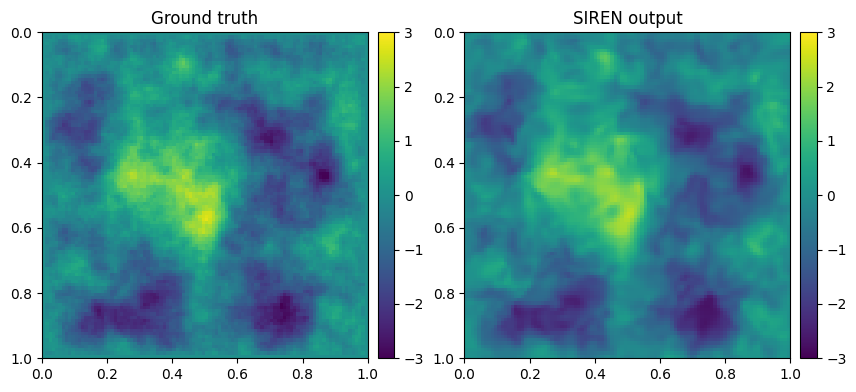

In [8]:
plot_predictions(img_siren, "SIREN")

# Vanilla MLP

In [9]:
from models.mlp import MultilayerPerceptron


mlp = MultilayerPerceptron(in_features=2, out_features=1, hidden_features=256, hidden_layers=3)
mlp.cuda()

num_epochs = 500
optim = torch.optim.Adam(lr=1e-4, params=mlp.parameters())

train_model(mlp, my_dataloader, optim, num_epochs)

Epoch 0: loss 0.09858281165361404
Epoch 1: loss 0.0999603345990181
Epoch 2: loss 0.08931993693113327
Epoch 3: loss 0.09362074732780457
Epoch 4: loss 0.10162284225225449
Epoch 5: loss 0.08213942497968674
Epoch 6: loss 0.10524848103523254
Epoch 7: loss 0.09580816328525543
Epoch 8: loss 0.1113806888461113
Epoch 9: loss 0.0881020575761795
Epoch 10: loss 0.08722835034132004
Epoch 11: loss 0.10006505250930786
Epoch 12: loss 0.09522194415330887
Epoch 13: loss 0.07238122075796127
Epoch 14: loss 0.07834894210100174
Epoch 15: loss 0.07596606016159058
Epoch 16: loss 0.08252260088920593
Epoch 17: loss 0.08059114217758179
Epoch 18: loss 0.0723598301410675
Epoch 19: loss 0.07958229631185532
Epoch 20: loss 0.07564407587051392
Epoch 21: loss 0.07398141920566559
Epoch 22: loss 0.07281923294067383
Epoch 23: loss 0.0837729200720787
Epoch 24: loss 0.06613227725028992
Epoch 25: loss 0.06355307251214981
Epoch 26: loss 0.06122606247663498
Epoch 27: loss 0.06445576995611191
Epoch 28: loss 0.06032359600067139


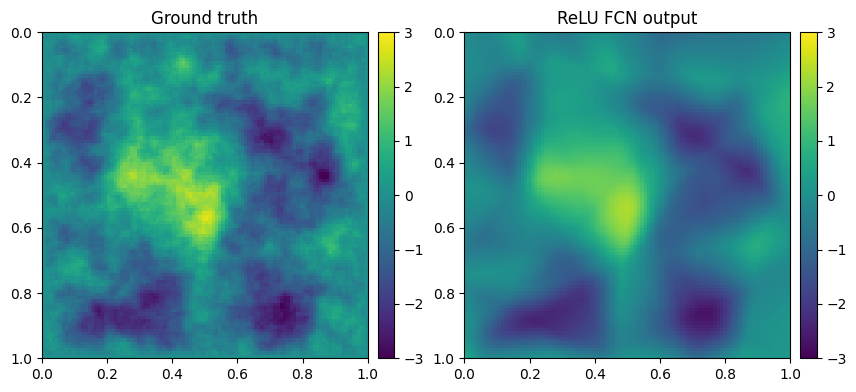

In [10]:
plot_predictions(mlp, "ReLU FCN")

# Positional encoding

In [12]:
from models.mlp import PositionalEncoding


pe = PositionalEncoding(in_features=2, mapping_size=256, out_features=1, hidden_features=256, hidden_layers=3)
pe.cuda()

num_epochs = 500
optim = torch.optim.Adam(lr=1e-4, params=pe.parameters())

train_model(pe, my_dataloader, optim, num_epochs)

Epoch 0: loss 0.1029323935508728
Epoch 1: loss 0.07518558949232101
Epoch 2: loss 0.0788341537117958
Epoch 3: loss 0.0686408057808876
Epoch 4: loss 0.04777875542640686
Epoch 5: loss 0.03630467876791954
Epoch 6: loss 0.029333151876926422
Epoch 7: loss 0.022735124453902245
Epoch 8: loss 0.018161088228225708
Epoch 9: loss 0.020374489948153496
Epoch 10: loss 0.01592194102704525
Epoch 11: loss 0.017738135531544685
Epoch 12: loss 0.0146125927567482
Epoch 13: loss 0.014865920878946781
Epoch 14: loss 0.013004687614738941
Epoch 15: loss 0.014888269826769829
Epoch 16: loss 0.011377701535820961
Epoch 17: loss 0.009995872154831886
Epoch 18: loss 0.010092080570757389
Epoch 19: loss 0.011392278596758842
Epoch 20: loss 0.009611699730157852
Epoch 21: loss 0.012109868228435516
Epoch 22: loss 0.009231801144778728
Epoch 23: loss 0.008380984887480736
Epoch 24: loss 0.008450096473097801
Epoch 25: loss 0.007970193400979042
Epoch 26: loss 0.0070523228496313095
Epoch 27: loss 0.006502479314804077
Epoch 28: los

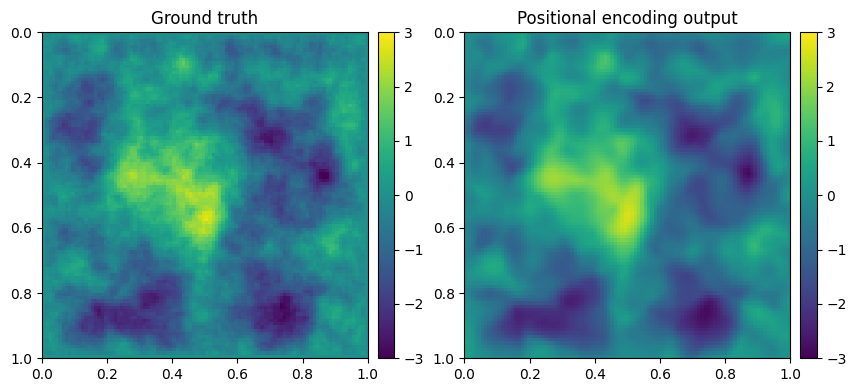

In [13]:
plot_predictions(pe, "Positional encoding")

In [29]:
from models.gpr import ExactGPR
import gpytorch
from gpytorch.kernels import MaternKernel, ScaleKernel

likelihood = gpytorch.likelihoods.GaussianLikelihood()
kernel = ScaleKernel(MaternKernel(ard_num_dims=2, nu=1.5))
model = ExactGPR(tensor_x/100, tensor_y, likelihood, kernel=kernel)
model.covar_module.base_kernel.register_constraint("raw_lengthscale",
                                                    gpytorch.constraints.Interval(1e-5, 1)
                                                    )

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

training_iter = 100
for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(tensor_x/100)
    # Calc loss and backprop gradients
    loss = -mll(output, tensor_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.base_kernel.lengthscale[0,0].item(),
        model.likelihood.noise.item()
    ))
    optimizer.step()

    

Iter 1/100 - Loss: 0.963   lengthscale: 0.500   noise: 0.693
Iter 2/100 - Loss: 0.928   lengthscale: 0.475   noise: 0.644
Iter 3/100 - Loss: 0.889   lengthscale: 0.450   noise: 0.598
Iter 4/100 - Loss: 0.853   lengthscale: 0.425   noise: 0.554
Iter 5/100 - Loss: 0.818   lengthscale: 0.401   noise: 0.513
Iter 6/100 - Loss: 0.776   lengthscale: 0.377   noise: 0.474
Iter 7/100 - Loss: 0.740   lengthscale: 0.354   noise: 0.437
Iter 8/100 - Loss: 0.697   lengthscale: 0.331   noise: 0.403
Iter 9/100 - Loss: 0.660   lengthscale: 0.309   noise: 0.370
Iter 10/100 - Loss: 0.621   lengthscale: 0.287   noise: 0.340
Iter 11/100 - Loss: 0.584   lengthscale: 0.267   noise: 0.312
Iter 12/100 - Loss: 0.549   lengthscale: 0.248   noise: 0.285
Iter 13/100 - Loss: 0.507   lengthscale: 0.230   noise: 0.261
Iter 14/100 - Loss: 0.468   lengthscale: 0.214   noise: 0.238
Iter 15/100 - Loss: 0.437   lengthscale: 0.199   noise: 0.218
Iter 16/100 - Loss: 0.402   lengthscale: 0.185   noise: 0.198
Iter 17/100 - Los

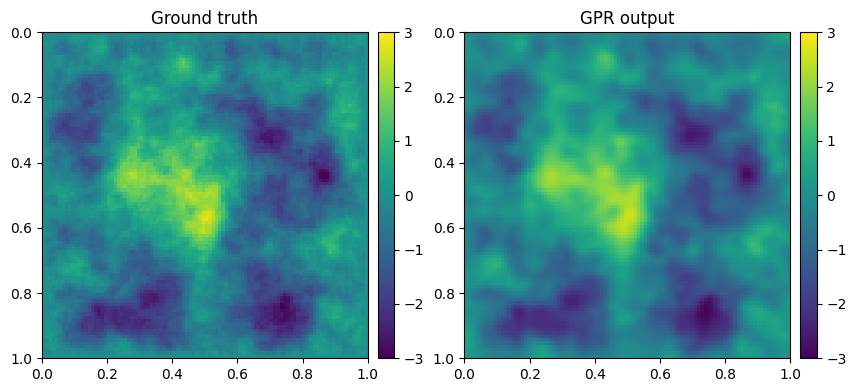

In [30]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    X_test = torch.Tensor(all_idxs)
    pred_f = model(X_test/100)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

    divider1 = make_axes_locatable(ax1)
    im1 = ax1.imshow(u, extent=[0,1,1,0], vmin=-3, vmax=3)
    ax1.set_title('Ground truth')
    cax1 = divider1.append_axes('right', size='5%', pad=0.1)
    fig.colorbar(im1, cax=cax1, orientation='vertical')

    divider2 = make_axes_locatable(ax2)
    im2 = ax2.imshow(pred_f.mean.reshape(98,98).cpu().detach().numpy(), extent=[0,1,1,0], vmin=-3, vmax=3)
    ax2.set_title('GPR output')
    cax2 = divider2.append_axes('right', size='5%', pad=0.1)
    fig.colorbar(im2, cax=cax2, orientation='vertical')